# Figure 3 Gene repertoire dynamics in ambrosia fungi


In [3]:
library(dplyr)
library(tidyr)

# Load your dataset
orthog_long <- read.csv('data/Orthogroups_meta_db_tool_annot_toolMod_CZAyme_substrate.csv')

# Define tools factor
tools <- factor(c('CAZyme','Cellulose','Chitin','CSEPs','Cytochrome P450',
                  'FCWDE','GH19','Glucan','Hemicellulose','Lignin','Lipase',
                  'Mannan','PCWDE','Pectin','Peptidases','Peptidoglycan',
                  'Resistance','Sucrose','Virulence', 'GPCRs'))

# Create tool_final column with additional checks
orthog_long <- orthog_long %>%
  mutate(tool_final = ifelse(!is.na(tool_substrate) & tool_substrate != "", tool_substrate, tool))

# Perform the required transformations
df <- orthog_long %>%
  select(Orthogroup, n_genes_genome, Ambrosia, acc, tool_final) %>%
  distinct() %>%
  mutate(Ambrosia = ifelse(Ambrosia == 'N', 'Non_Ambrosia', 'Ambrosia')) %>%
  group_by(Ambrosia, tool_final, Orthogroup) %>%
  summarize(mean = median(n_genes_genome)) %>%
  spread(Ambrosia, mean) %>%
  replace_na(list(Ambrosia = 0, Non_Ambrosia = 0)) %>%
  group_by(tool_final, Ambrosia, Non_Ambrosia) %>%
  mutate(NumberGenes = n()) %>%
  ungroup() %>% 
  select(-Orthogroup) %>%
  distinct()

# Perform the required transformations for df_ortho
df_ortho <- orthog_long %>%
  select(Orthogroup, n_genes_genome, Ambrosia, acc, tool_final) %>%
  distinct() %>%
  mutate(Ambrosia = ifelse(Ambrosia == 'N', 'Non_Ambrosia', 'Ambrosia')) %>%
  group_by(Ambrosia, tool_final, Orthogroup) %>%
  summarize(mean = median(n_genes_genome)) %>%
  spread(Ambrosia, mean) %>%
  replace_na(list(Ambrosia = 0, Non_Ambrosia = 0)) %>%
  group_by(tool_final, Ambrosia, Non_Ambrosia) %>%
  mutate(NumberGenes = n()) %>%
  ungroup() %>% 
  distinct()

# Calculate the ratios for each tool_final
ratios_df <- lapply(levels(tools), function(x){
  # Loss
  a <- df %>% dplyr::filter(tool_final == x) %>%
    filter(Ambrosia == 0 , Non_Ambrosia > 0) %>%
    summarize(value = sum(NumberGenes)) %>%
    mutate(tool_final = x) %>%
    mutate(type = 'Loss')
  
  # Gain
  b <- df %>% dplyr::filter(tool_final == x) %>%
    filter(Ambrosia > 0 , Non_Ambrosia == 0) %>%
    summarize(value = sum(NumberGenes)) %>%
    mutate(tool_final = x) %>%
    mutate(type = 'Gain')
  
  # Combine results
  bind_rows(a, b) %>% spread(type, value) %>%
    mutate(ratio = Gain / Loss) %>%
    arrange(ratio)
}) %>% bind_rows()

# Merge ratios_df with df
df <- df %>% 
  left_join(., ratios_df, by = 'tool_final') %>%
  mutate(label = paste0(tool_final, " (", Gain, ":", Loss, ")"))

# Display the final ratios dataframe
print(ratios_df)

# Write the df_ortho to a CSV file
write.csv(df_ortho, "data/Orthogroups_meta_db_tool_annot_gainloss_label_orthogroup.csv", row.names = FALSE)


`summarise()` has grouped output by 'Ambrosia', 'tool_final'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Ambrosia', 'tool_final'. You can override
using the `.groups` argument.


# A tibble: 20 × 4
   tool_final       Gain  Loss ratio
   <chr>           <int> <int> <dbl>
 1 CAZyme            619   554 1.12 
 2 Cellulose          37    46 0.804
 3 Chitin             26    25 1.04 
 4 CSEPs             215   271 0.793
 5 Cytochrome P450   415   686 0.605
 6 FCWDE              66    70 0.943
 7 GH19              119   238 0.5  
 8 Glucan             21    25 0.84 
 9 GPCRs              18    22 0.818
10 Hemicellulose      23    27 0.852
11 Lignin              4     8 0.5  
12 Lipase           1119  2258 0.496
13 Mannan             13    17 0.765
14 PCWDE             110   123 0.894
15 Pectin             31    26 1.19 
16 Peptidases        679  1625 0.418
17 Peptidoglycan       1     3 0.333
18 Resistance        594   536 1.11 
19 Sucrose             2     1 2    
20 Virulence        1169  2562 0.456


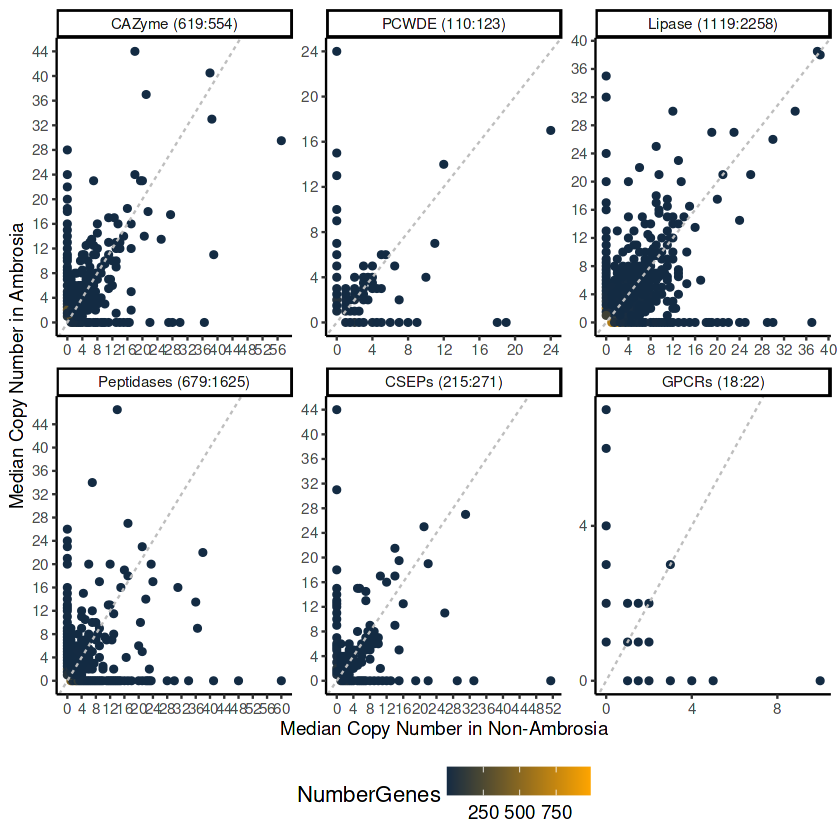

In [4]:
library(ggplot2)
library(dplyr)

# Create the plot
df$label2 <- factor(df$label, levels = unique(df$label)[c(1, 14, 12, 16, 4, 9)])

# Filter out rows where label2 is NA
df <- df %>% filter(!is.na(label2))

# Create a color gradient
colors_heat <- colorRampPalette(c("#132B43", "orange"))

# Create the plot
fig2a <- df %>%
  filter(tool_final != 'Single Copy Genes') %>%
  ggplot(aes(x = Non_Ambrosia, y = Ambrosia)) +
  geom_point(aes(color = NumberGenes), size = 1.5) +  # Use a smaller size for points
  scale_color_gradientn(colors = colors_heat(10)) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = 'grey') +
  facet_wrap(~label2, scales = 'free') +
  theme_classic() +
  theme(legend.position = 'bottom',
        legend.text = element_text(size = 11),  # Adjust legend text size here
        legend.title = element_text(size = 13)) +  # Adjust legend title size here
  labs(y = 'Median Copy Number in Ambrosia',
       x = 'Median Copy Number in Non-Ambrosia') +
  scale_x_continuous(breaks = seq(0, max(df$Non_Ambrosia, na.rm = TRUE), by = 4),  # More spaced out ticks
                     labels = seq(0, max(df$Non_Ambrosia, na.rm = TRUE), by = 4)) +
  scale_y_continuous(breaks = seq(0, max(df$Ambrosia, na.rm = TRUE), by = 4),  # More spaced out ticks
                     labels = seq(0, max(df$Ambrosia, na.rm = TRUE), by = 4)) +
  theme(legend.position = 'bottom')

fig2a

# Save the plot to a PDF
ggsave("functional_gene_median.pdf", plot = fig2a, device = "pdf", width = 10, height = 7.5, path = ".")


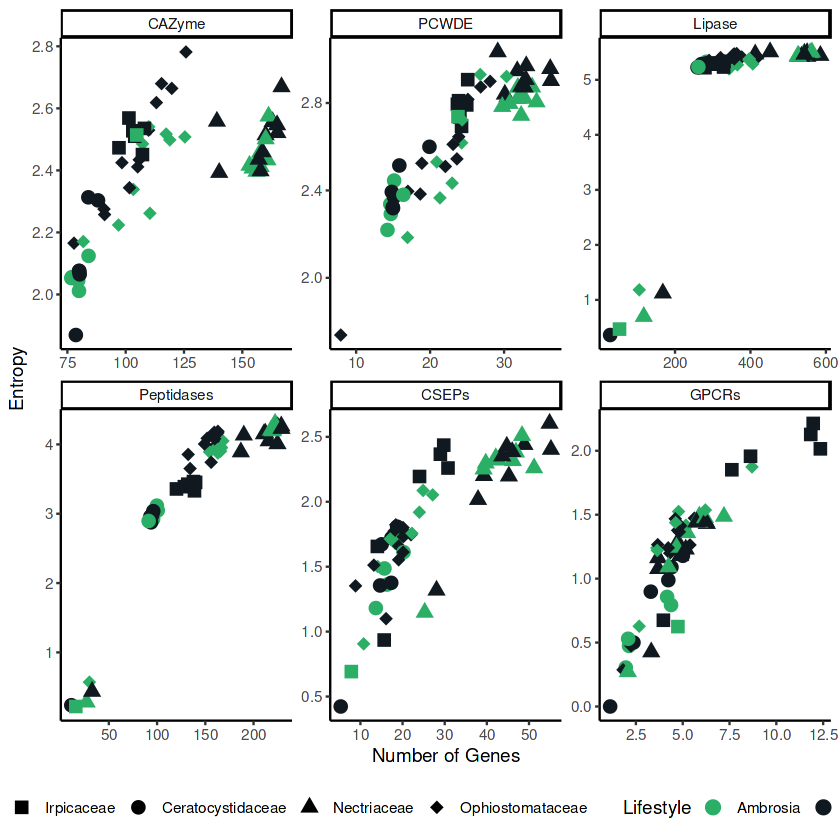

In [5]:
library(ggplot2)
library(dplyr)

# Load the data
diversity_indices <- read.csv('data/all_diversity_indices_with_acc_ambrosia.csv')

# Remove rows where Ambrosia == 'outgroup'
diversity_indices <- diversity_indices %>%
  filter(Ambrosia != 'outgroup')

# Adjusting factor levels for 'Ambrosia' to have descriptive labels
diversity_indices$Ambrosia <- factor(diversity_indices$Ambrosia,
                                     levels = c('Y', 'N'),
                                     labels = c('Ambrosia', 'Non-Ambrosia'))

# Ordering the 'Family' factor according to specified levels
diversity_indices$Family <- factor(diversity_indices$Family,
                                   levels = c('Irpicaceae', 'Ceratocystidaceae', 'Nectriaceae', 'Ophiostomataceae'))

# Define the color map
color_map <- c('Ambrosia' = '#2BAE66FF', 'Non-Ambrosia' = '#101820FF')

# Set the order of 'tool' categories
#diversity_indices$tool <- factor(diversity_indices$tool, levels = c('CAZyme', 'Lipase', 'Peptidases', 'CSEPs','Cytochrome P450', 'Resistance', 'Virulence', 'GH19'))

diversity_indices$tool2 <- factor(diversity_indices$tool, levels = c('CAZyme', 'PCWDE', 'Lipase', 'Peptidases', 'CSEPs', 'GPCRs'))
diversity_indices <- diversity_indices %>% filter(!is.na(tool2))

# Create the ggplot
g <- diversity_indices %>%
#  filter(tool != 'GH19') %>%
  ggplot(aes(x = S, y = H, color = Ambrosia, shape = Family)) +
  geom_jitter(size = 3.5) +
  scale_color_manual(values = color_map, 
                     name = "Lifestyle", 
                     labels = c('Ambrosia', 'Non-Ambrosia')) +
  theme_classic() +
  theme(legend.position = 'bottom') +
  labs(y = 'Entropy', x = 'Number of Genes') +
  facet_wrap(~tool2, scales = 'free') +
  scale_shape_manual(values = c(15, 16, 17, 18))

g
ggsave("functional_gene_diversity.pdf", plot = g, device = "pdf", width = 10, height = 7.5, path = ".")

In [ ]:
diversity_indices$tool2

library(ggplot2)
library(dplyr)

# Load the data
diversity_indices <- read.csv('data/all_diversity_indices_with_acc_ambrosia.csv')

# Remove rows where Ambrosia == 'outgroup'
diversity_indices <- diversity_indices %>%
  filter(Ambrosia != 'outgroup')

# Adjusting factor levels for 'Ambrosia' to have descriptive labels
diversity_indices$Ambrosia <- factor(diversity_indices$Ambrosia,
                                     levels = c('Y', 'N'),
                                     labels = c('Ambrosia', 'Non-Ambrosia'))

# Ordering the 'Family' factor according to specified levels
diversity_indices$Family <- factor(diversity_indices$Family,
                                   levels = c('Irpicaceae', 'Ceratocystidaceae', 'Nectriaceae', 'Ophiostomataceae'))

# Define the color map
color_map <- c('Ambrosia' = '#2BAE66FF', 'Non-Ambrosia' = '#101820FF')

# Set the order of 'tool' categories
diversity_indices$tool2 <- factor(diversity_indices$tool, levels = c('CAZyme', 'PCWDE','Lipase', 'Peptidases', 'CSEPs', 'GPCRs'))
diversity_indices <- diversity_indices %>% filter(!is.na(tool2))

# Create the ggplot
g <- diversity_indices %>%
#  filter(tool2 != 'GH19') %>%
  ggplot(aes(x = S, y = H, color = Ambrosia, shape = Family)) +
#  ggplot(aes(x = evenness, y = H, color = Ambrosia, shape = Family)) +
  geom_jitter(size = 3.5) +
  scale_color_manual(values = color_map, 
                     name = "Lifestyle", 
                     labels = c('Ambrosia', 'Non-Ambrosia')) +
  theme_classic() +
  theme(legend.position = 'bottom',
        legend.text = element_text(size = 11),  # Adjust legend text size here
        legend.title = element_text(size = 13)) +  # Adjust legend title size here
  labs(y = 'Entropy', x = 'Gene Richness') +
  facet_wrap(~tool2, scales = 'free') +
  scale_shape_manual(values = c(15, 16, 17, 18))

# Adding p-value annotations for each tool, including "Resistance"
g <- g + geom_text(data = diversity_indices %>% 
                   filter(tool2 %in% c('CAZyme', 'PCWDE', 'GPCRs','Lipase', 'Peptidases', 'CSEPs')), 
                   aes(x = Inf, y = Inf, label = ifelse(tool2 == "CAZyme", "                                                          Lifestyle: p=0.006\nPhylogeny: p=4.30E-31",
                                                 ifelse(tool2 == "PCWDE", "                                                                      Lifestyle: p=0.38\nPhylogeny: p=2.36E-13", 
                                                 ifelse(tool2 == "GPCRs", "                                                                       Lifestyle: p=0.35\nPhylogeny: p=2.44E-12", 
                                                 ifelse(tool2 == "Lipase", "                                                                      Lifestyle: p=0.44\nPhylogeny: p=3.28E-08", 
                                                 ifelse(tool2 == "Peptidases", "                                                         Lifestyle: p=0.577\nPhylogeny: p=5.03E-11", 
                                                 ifelse(tool2 == "CSEPs", "                                                              Lifestyle: p=0.419\nPhylogeny: p=1.10E-09", ""))))))), 
                   hjust = 1.2, vjust = 9, size = 3)

g

ggsave("functional_gene_diversity_with_p_values.pdf", plot = g, device = "pdf", width = 10, height = 7.5, path = ".")

# Figure 4. Bubble plot of CAZyme significant in PIC analysis

In [ ]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(readr)

# Load the CAZyme data
cazyme_file_path <- "data/Orthogroups_meta_db_tool_annot_toolMod_CZAyme_substrate.csv"
cazyme_data <- read_csv(cazyme_file_path)

# Load the Ambrosia data
ambrosia_file_path <- "data/AmbrosiaFungiGenomeFeature_remove_zygo.csv"
ambrosia_data <- read_csv(ambrosia_file_path)

# Filter the CAZyme data where 'tool' is 'CAZyme'
cazyme_filtered <- cazyme_data %>% filter(tool == "CAZyme")

# Count the occurrences of each unique 'annotation' for each 'acc'
cazyme_counts <- cazyme_filtered %>%
  group_by(acc, annotation) %>%
  summarize(count = n(), .groups = 'drop')

# Filter out rows where annotation is "-"
cazyme_counts_filtered <- cazyme_counts %>%
  filter(annotation != "-")

# Pivot the data to create a matrix suitable for analysis
cazyme_matrix <- cazyme_counts_filtered %>%
  spread(key = annotation, value = count, fill = 0)

# Merge with ambrosia data using left join to ensure all ambrosia data is included
merged_data <- ambrosia_data %>%
  select(FungusName_Strain, Ambrosia) %>%
  left_join(cazyme_matrix, by = c("FungusName_Strain" = "acc"))

# Fill NA values with zeros for annotation counts
merged_data <- merged_data %>% replace(is.na(.), 0)

# Filter out rows where Ambrosia is 'NA'
merged_data <- merged_data %>% filter(Ambrosia != "NA")

# Add the "Family" column from the original CAZyme data
family_column <- cazyme_data %>%
  select(acc, Family) %>%
  distinct() %>%
  rename(FungusName_Strain = acc)

merged_data <- merged_data %>%
  left_join(family_column, by = "FungusName_Strain")

# Reorder columns to have "Family" as the third column
col_order <- c("FungusName_Strain", "Ambrosia", "Family", setdiff(names(merged_data), c("FungusName_Strain", "Ambrosia", "Family")))
merged_data <- merged_data %>% select(all_of(col_order))

# Export the updated merged data to a CSV file
write_csv(merged_data, "data/CAZyme_merged_data.csv")


In [ ]:
# Log normalize the CAZyme counts for each group
log_normalized_data <- merged_data %>%
  mutate(across(-c(FungusName_Strain, Ambrosia, Family), ~ log1p(.)))

# Drop columns with NaN values
log_normalized_data <- log_normalized_data %>%
  select(where(~ !any(is.nan(.))))

# Export the log-normalized data to a CSV file
write_csv(log_normalized_data, "data/CAZyme_log_normalized_data.csv")

In [ ]:
# Load necessary libraries
library(ape)
library(phangorn)
library(dplyr)
library(tidyr)
library(readr)

# Load the phylogenetic tree for all species
all_species_tree_file_path <- "data/concat_nooutgroup_rooted.contree"
all_species_tree <- read.tree(all_species_tree_file_path)

# Load the traits data
traits_file_path <- "data/CAZyme_log_normalized_data.csv"
traits_data <- read_csv(traits_file_path)

# Ensure that the species names in traits match the tree
traits_data$species <- factor(traits_data$FungusName_Strain, levels = all_species_tree$tip.label)

# Create the Ambrosia predictor
ambrosia_predictor <- ifelse(traits_data$Ambrosia == 'Y', 1, 0)

# Function to perform PIC analysis and summarize results
perform_pic_analysis <- function(traits_data, tree, ambrosia_predictor) {
  # Use all columns except the first and second as trait_list
  trait_list <- colnames(traits_data)[!colnames(traits_data) %in% c("FungusName_Strain", "Ambrosia", "species")]

  # Initialize a list to store PIC results
  pic_results <- list()

  # Loop through each trait and compute PIC, storing results
  for(trait in trait_list) {
    trait_values <- traits_data[[trait]]
    if(all(!is.na(trait_values)) && all(is.finite(trait_values))) {  # check if there are no missing values and all are finite
      pic_results[[trait]] <- pic(trait_values, tree)
    }
  }

  # Function to match node contrasts with predictor values
  match_pic_to_predictor <- function(pic_values, tree, predictor) {
    node_values <- pic_values
    internal_nodes <- (length(tree$tip.label) + 1):(length(tree$tip.label) + length(node_values))
    
    predictor_aligned <- numeric(length(node_values))
    
    for (i in 1:length(node_values)) {
      node <- internal_nodes[i]
      descendants <- Descendants(tree, node, type = "tips")[[1]]
      predictor_values <- predictor[descendants]
      predictor_aligned[i] <- mean(predictor_values)
    }
    
    return(predictor_aligned)
  }

  # Align the predictor values with the PIC results
  aligned_predictor <- lapply(pic_results, match_pic_to_predictor, tree = tree, predictor = ambrosia_predictor)

  # Convert the PIC results to a data frame for analysis
  pic_data <- as.data.frame(do.call(cbind, lapply(pic_results, as.numeric)))
  colnames(pic_data) <- names(pic_results)

  # Convert the aligned predictor to a data frame
  aligned_predictor_df <- as.data.frame(do.call(cbind, aligned_predictor))
  colnames(aligned_predictor_df) <- paste0(names(aligned_predictor), "_predictor")

  # Combine the PIC data and aligned predictor data
  combined_data <- cbind(pic_data, aligned_predictor_df)

  # Fit a linear model for each trait and store the results
  lm_results <- list()

  for(trait in names(pic_results)) {
    trait_predictor <- paste0(trait, "_predictor")
    lm_results[[trait]] <- summary(lm(combined_data[[trait]] ~ combined_data[[trait_predictor]]))
  }

  # Summarize the linear model results for each trait
  summary_results <- data.frame(
    Trait = character(),
    Predictor = character(),
    Estimate = numeric(),
    StdError = numeric(),
    tValue = numeric(),
    pValue = numeric(),
    stringsAsFactors = FALSE
  )

  for(trait in names(pic_results)) {
    trait_predictor <- paste0(trait, "_predictor")
    lm_summary <- lm_results[[trait]]
    summary_results <- rbind(summary_results, data.frame(
      Trait = trait,
      Predictor = trait_predictor,
      Estimate = lm_summary$coefficients[2, "Estimate"],
      StdError = lm_summary$coefficients[2, "Std. Error"],
      tValue = lm_summary$coefficients[2, "t value"],
      pValue = lm_summary$coefficients[2, "Pr(>|t|)"]
    ))
  }

  return(summary_results)
}

# Perform analysis for all species
all_species_results <- perform_pic_analysis(traits_data, all_species_tree, ambrosia_predictor)
write_csv(all_species_results, "data/CAZyme_PIC_test_summary_results_all_species.csv")



In [ ]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)
library(readr)

# Plotting function
plot_results <- function(significant_results_path, merged_data_path, ambrosia_file_path, output_plot_path, family_name = NULL, plot_width = 10, plot_height = 10) {
  # Load significant results
  significant_results <- read_csv(significant_results_path)
  
  # Extract significant CAZyme groups based on p-value < 0.05
  significant_cazyme_groups <- significant_results %>%
    filter(pValue < 0.05) %>%
    pull(Trait)
  
  # Load the data
  dat <- read_csv(merged_data_path)
  
  # Load the Ambrosia data to get CladeOrder
  ambrosia_data <- read_csv(ambrosia_file_path)
  
  # Filter data by family if family_name is provided
  if (!is.null(family_name)) {
    dat <- dat %>%
      filter(Family == family_name)
    ambrosia_data <- ambrosia_data %>%
      filter(FungusName_Strain %in% dat$FungusName_Strain)
  }
  
  # Ensure the significant CAZyme groups exist in the data
  existing_cazyme_groups <- intersect(significant_cazyme_groups, colnames(dat))
  
  # Merge the normalized data with CladeOrder
  bubble_data <- dat %>%
    inner_join(ambrosia_data %>% select(FungusName_Strain, CladeOrder), by = c("FungusName_Strain" = "FungusName_Strain")) %>%
    select(FungusName_Strain, Ambrosia, CladeOrder, all_of(existing_cazyme_groups))
  
  # Filter out the outgroup "Ambrosia"
  bubble_data <- bubble_data %>%
    filter(Ambrosia != "outgroup")
  
  # Arrange the data by CladeOrder in descending order
  bubble_data <- bubble_data %>%
    arrange(CladeOrder)
  
  # Convert the data to a long format for ggplot2
  bubble_data_long <- bubble_data %>%
    gather(key = "CAZyme_Group", value = "Observed_Number", -FungusName_Strain, -Ambrosia, -CladeOrder)
  
  # Filter out rows with Observed_Number equal to 0
  bubble_data_long <- bubble_data_long %>%
    filter(Observed_Number != 0)
  
  # Ensure the order of the species for the plot is based on CladeOrder in descending order
  bubble_data_long <- bubble_data_long %>%
    mutate(FungusName_Strain = factor(FungusName_Strain, levels = rev(unique(bubble_data$FungusName_Strain))))
  
  # Create a new column for CAZyme group based on the first two letters
  bubble_data_long <- bubble_data_long %>%
    mutate(CAZyme_Group_Short = substr(CAZyme_Group, 1, 2))
  
  # Merge with significant results to get the Estimate for coloring
  bubble_data_long <- bubble_data_long %>%
    left_join(significant_results %>% select(Trait, Estimate), by = c("CAZyme_Group" = "Trait"))
  
  # Create the bubble plot with white background and no grid lines
  p <- ggplot(bubble_data_long, aes(x = CAZyme_Group, 
                                    y = FungusName_Strain, 
                                    color = Estimate, 
                                    size = Observed_Number)) +
    geom_point(alpha = 0.7) +
    scale_size_continuous(name = "Observed Number", range = c(3, 15)) +  # Increase bubble size range
    scale_color_gradient2(low = "red", mid = "white", high = "darkblue", midpoint = 0, name = "Association Strength") +  # Use gradient for association strength
    geom_text(aes(label = Observed_Number), vjust = 0.5, hjust = 0.5, colour = "white", size = 2) +  # Add text labels
    theme_minimal(base_size = 15) +
    theme(panel.background = element_rect(fill = "white", color = NA),
          plot.background = element_rect(fill = "white", color = NA),
          panel.grid = element_blank(),  # Remove grid lines
          axis.text.x = element_text(angle = 45, hjust = 0),
          axis.text.y = element_text(size = 8),
          plot.title = element_text(hjust = 0.5),
          plot.margin = margin(t = 1, r = 1, b = 1, l = 1, unit = "cm"),
          axis.title.x = element_blank(),  # Remove x-axis title from the bottom
          axis.title.x.top = element_text()) +  # Add x-axis title to the top
    labs(title = paste("Significant CAZymes Associated with Ambrosia Lifestyle", if (!is.null(family_name)) paste("in", family_name) else ""),
         x = "",
         y = "") +
    scale_x_discrete(position = "top")  # Move x-axis to the top
  
  # Save the plot as a PDF with adjusted size
  ggsave(output_plot_path, plot = p, width = plot_width, height = plot_height, units = "in")
  
  # Print the plot to the screen
  print(p)
}

# Paths to input files and output directories
ambrosia_file_path <- "data/AmbrosiaFungiGenomeFeature_remove_zygo.csv"
merged_data_path <- "data/CAZyme_merged_data.csv"


# Generate plots for all species with adjusted size
plot_results("data/CAZyme_PIC_test_summary_results_all_species.csv", merged_data_path, ambrosia_file_path, file.path("CAZyme_bubble_plot_all_species.pdf"), plot_width = 10, plot_height = 13)  # Adjust the width and height as needed

# Specify plot sizes for each family
family_plot_sizes <- list(
  Ophiostomataceae = c(7.5, 10),
  Nectriaceae = c(8.5, 10),
  Ceratocystidaceae = c(11, 10),
  Irpicaceae = c(7, 7)
)


# Phylogenemic concordance analysis

In [ ]:
# Function to clean up the support values in the Newick format data
clean_support_values <- function(newick_str) {
  # Pattern to match nodes with four support values and transform them to three
  pattern_four <- "(\\d+)/(\\d+)/(\\d+\\.?\\d*)/(\\d+\\.?\\d*)"
  # Transform four values to three by removing the second value
  cleaned_str <- gsub(pattern_four, "\\1/\\3/\\4", newick_str)
  
  # Pattern to match nodes with more than three support values and handle them
  pattern_more <- "(\\d+)/(\\d+\\.?\\d*)/(\\d+\\.?\\d*)/(\\d+\\.?\\d*)"
  cleaned_str <- gsub(pattern_more, "\\1/\\2/\\3", cleaned_str)
  
  return(cleaned_str)
}

# Path to the original file
file_path <- "data/concord.cf.tree"

# Read the file content
newick_content <- readLines(file_path, warn = FALSE)
newick_content <- paste(newick_content, collapse = "")

# Clean the content
cleaned_content <- clean_support_values(newick_content)

# Save the cleaned content back to a file
cleaned_file_path <- "cleaned_concord.cf.tree"
writeLines(cleaned_content, cleaned_file_path)

cat("Cleaned file saved to:", cleaned_file_path, "\n")


Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



'data.frame':	67 obs. of  19 variables:
 $ ID    : int  71 72 73 74 75 76 77 78 79 80 ...
 $ gCF   : num  4.13 49.45 13.99 19.01 40.99 ...
 $ gCF_N : int  29 361 102 138 298 322 631 207 271 675 ...
 $ gDF1  : num  4.56 0.82 5.21 2.48 7.02 ...
 $ gDF1_N: int  32 6 38 18 51 58 1 80 99 11 ...
 $ gDF2  : num  66.24 7.26 3.02 1.38 1.79 ...
 $ gDF2_N: int  465 53 22 10 13 45 1 166 161 6 ...
 $ gDFP  : num  25.1 42.5 77.8 77.1 50.2 ...
 $ gDFP_N: int  176 310 567 560 365 307 94 264 191 41 ...
 $ gN    : int  702 730 729 726 727 732 727 717 722 733 ...
 $ sCF   : num  16.3 77.4 60.4 30.6 54.6 ...
 $ sCF_N : num  87.3 890.7 1423 545.5 992.1 ...
 $ sDF1  : num  73.69 3.96 22.32 42.77 18.66 ...
 $ sDF1_N: num  425.1 54.9 340.3 1149.4 335.4 ...
 $ sDF2  : num  10.1 18.6 17.3 26.6 26.7 ...
 $ sDF2_N: num  44.3 302.1 309.7 469.3 685 ...
 $ sN    : num  557 1248 2073 2164 2012 ...
 $ Label : int  100 100 95 100 100 100 100 99 100 100 ...
 $ Length: num  0.000852 0.012377 0.004676 0.017599 0.010672 ..

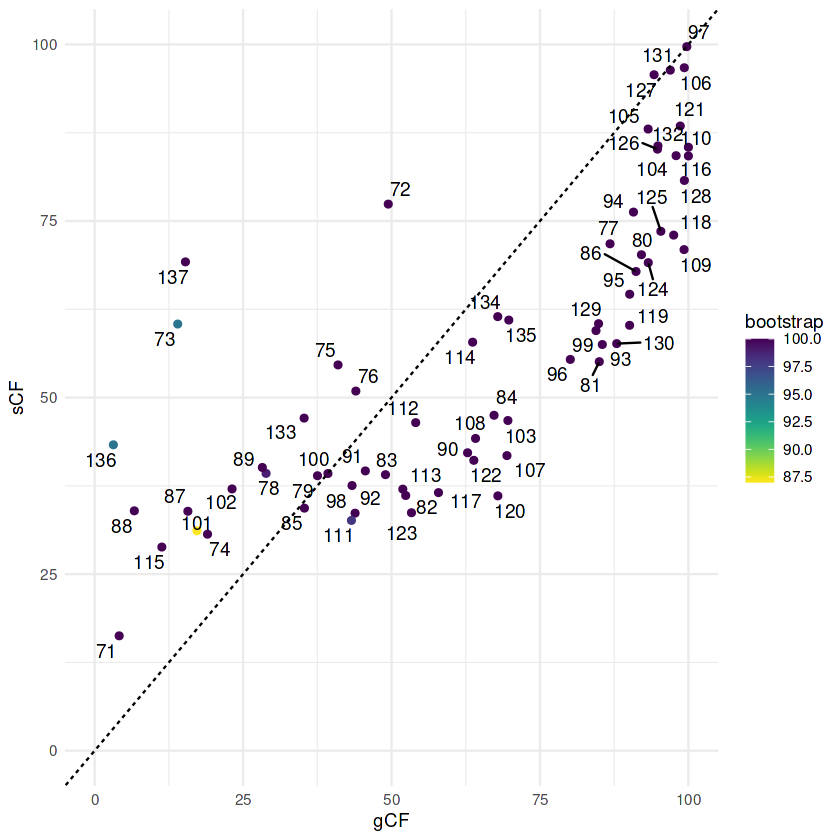

In [6]:
library(viridis)
library(ggplot2)
library(dplyr)
library(ggrepel)
library(GGally)
library(entropy)

# Read the data
d = read.delim("data/concord.cf.stat", header = T, comment.char='#')

# Check the structure of the data frame
str(d)

# Rename columns (if necessary)
names(d)[names(d) == "Label"] = "bootstrap"
# Note: We're not renaming sCF to keep it consistent with the original data

# Check the structure again after renaming
#str(d)

# Plot the values
# ggplot(d, aes(x = gCF, y = sCF)) + 
#     geom_point(aes(colour = bootstrap)) + 
#     scale_colour_viridis(direction = -1) + 
#     xlim(0, 100) +
#     ylim(0, 100) +
#     geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
#     labs(x = "Gene Concordance Factor (gCF)", 
#          y = "Site Concordance Factor (sCF)",
#          colour = "Bootstrap",
#          title = "Concordance Factors Comparison") +
#     theme_minimal()

# Display the first few rows of the data

ggplot(d, aes(x = gCF, y = sCF, label = ID)) + 
    geom_point(aes(colour = bootstrap)) + 
    scale_colour_viridis(direction = -1) + 
    xlim(0, 100) +
    ylim(0, 100) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
    geom_text_repel()+
    theme_minimal()
#head(d)

In [7]:
chisq = function(DF1, DF2, N){
    tryCatch({
        counts <- c(round(DF1*N)/100, round(DF2*N)/100)
        if(sum(counts) < 20) {  # Use Fisher's exact test for small samples
            fisher.test(matrix(counts, nrow=2))$p.value
        } else {
            chisq.test(counts)$p.value
        }
    },
    error = function(err) {
        return(1.0)
    })
}

#dplyr::last_dplyr_warnings(n = 10)

e = d %>% 
    group_by(ID) %>%
    mutate(gEF_p = chisq(gDF1, gDF2, gN)) %>%
    mutate(sEF_p = chisq(sDF1, sDF2, sN))

e_sig <- subset(data.frame(e), (gEF_p < 0.05 | sEF_p < 0.05))
e_sig
write.csv(e_sig, "ILS_sig.csv", row.names = F)

,ID,gCF,gCF_N,gDF1,gDF1_N,gDF2,gDF2_N,gDFP,gDFP_N,gN,⋯,sCF_N,sDF1,sDF1_N,sDF2,sDF2_N,sN,bootstrap,Length,gEF_p,sEF_p
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,71,4.13,29,4.56,32,66.24,465,25.07,176,702,⋯,87.26,73.69,425.05,10.05,44.28,556.59,100,0.000851577,5.023345e-84,1.707660e-60
2,72,49.45,361,0.82,6,7.26,53,42.47,310,730,⋯,890.68,3.96,54.91,18.65,302.15,1247.74,100,0.012377500,9.316550e-10,1.003088e-27
3,73,13.99,102,5.21,38,3.02,22,77.78,567,729,⋯,1422.99,22.32,340.29,17.27,309.74,2073.02,95,0.004676270,3.935772e-02,2.578327e-04
4,74,19.01,138,2.48,18,1.38,10,77.13,560,726,⋯,545.50,42.77,1149.43,26.58,469.27,2164.20,100,0.017599100,1.316723e-01,1.504778e-19
5,75,40.99,298,7.02,51,1.79,13,50.21,365,727,⋯,992.10,18.66,335.38,26.72,685.02,2012.50,100,0.010671500,2.015199e-06,7.980284e-08
6,76,43.99,322,7.92,58,6.15,45,41.94,307,732,⋯,1352.50,19.11,536.83,29.96,970.36,2859.69,100,0.010275300,2.019331e-01,1.204072e-16
7,77,86.80,631,0.14,1,0.14,1,12.93,94,727,⋯,6110.41,16.40,1544.65,11.83,1091.92,8746.98,100,0.095224100,1.000000e+00,8.681598e-16
8,78,28.87,207,11.16,80,23.15,166,36.82,264,717,⋯,3328.02,26.83,2242.46,33.91,2824.02,8394.50,99,0.020030100,4.226044e-08,8.557954e-17
9,79,37.53,271,13.71,99,22.30,161,26.45,191,722,⋯,3884.46,27.25,2715.94,33.82,3416.51,10016.91,100,0.028525100,1.199066e-04,3.952778e-17
